In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rivapy.marketdata as mktdata

In [2]:
ssvi = mktdata.VolatilityParametrizationSSVI(expiries=[1.0/365, 30/365, 0.5, 1.0], fwd_atm_vols=[0.25, 0.3, 0.28, 0.25], rho=-0.9, eta=0.5, gamma=0.5)
svi = mktdata.VolatilityParametrizationSVI(expiries=np.array([1.0/365.0, 1.0]), svi_params=[
        (0.0001, 0.1, -0.5, 0.0, 0.0001),
        (0.0002, 0.1, -0.5, 0.0, 0.00004),
])

In [3]:
expiry = 100.0/365.0
x_strikes = np.linspace(0.9,1.1,50)
vols = svi.calc_implied_vol(expiry, x_strikes)

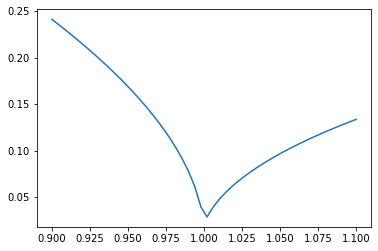

In [4]:
plt.plot(x_strikes, vols)

In [5]:
def calibrate(parametrization, quotes):
    

In [9]:
hasattr(d.__class__,'run2')

False

In [14]:
np.sqrt(0.0001*365)

0.19104973174542803